In [1]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
from math import sin, cos, sqrt, atan2, radians
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

# Residences

This notebook takes a look at any potential correlations between residence location and observations between animals

In [2]:
## Residences locations
def pointsOfInterest():
    residentials = {}
    residentials['56.8781465,-6.1326085'] = "historic memorial"
    residentials['56.9003152,-6.1404042'] = "historic monument"
    residentials['56.9199238,-6.1467235'] = "historic memorial"
    
    residentials['56.8797535,-6.1267920'] = "ferry_terminal"
    residentials['56.9190886,-6.1463398'] = "restaurant"
    residentials['56.8772214,-6.1306635'] = "postoffice"
    
    residentials['56.8772523, -6.1305778'] = "OK"
    
    residentials['56.8798083,-6.1462677'] = "Town Hall"
    residentials['56.8932164,-6.1448756'] = "Church"
    residentials['56.9025486,-6.1389638'] = "Primary School"
    residentials['56.9031345,-6.1392428'] = "Heritage Trust"
    residentials['56.917479,-6.1453462'] = "Roman Church"
    residentials['56.8802725,-6.1417391'] = "Eco Center"
    residentials['56.901693,-6.141992'] = "Old Museum"
    
    residentials['56.9199238,-6.1467235'] = 'Eigg War Memorial'
    
    residentials['56.8709333,-6.1213667'] = "lighthouse"
    
    return residentials
    

def residentialEntry():
    
    residentials = {}
    
    residentials['56.9218827,-6.1464040'] = "cleadale"
    residentials['56.8888173,-6.1227537'] = "kildonnan"
    residentials['56.8770948,-6.1389645'] = "Galmisdale"
    residentials['56.9285566,-6.1433419'] = "Howlin"
    residentials['56.8794302,-6.1776533'] = "Grulin"
    residentials['56.9190886,-6.1463398'] = 'Lageorna'
    
    residentials['56.9218827,-6.1464040'] = '<village>'
    residentials['56.8888173,-6.1227537'] = '<locality>'
    residentials['56.9285566,-6.1433419'] = '<village>'
    
    residentials['56.8794302,-6.1776533'] = '<locality>'
    
    residentials['56.9018832,-6.1449375'] ="1 Cuagach"
    residentials['56.907887,-6.1960333'] ="2 Cuagach"
    residentials['56.901695,-6.1419985'] ="A Nead" #knitwear - business?
    residentials['56.901837,-6.120534'] ="Brae Cottage" # estimate
    residentials['56.8804647,-6.1417635'] ="Earth Connections Sustainability Centre"
    residentials['56.9031345,-6.1392428'] ="Eigg Electric Ltd, An Laimhrig"
    residentials['56.902125,-6.142966'] ="Foresters Cottage"
    residentials['56.878903,-6.146895'] ="Galmisdale House"
    residentials['56.9272042,-6.1444563'] ="Howlin Cottage"
    residentials['56.928432,-6.144725'] ="Howlin House"
    residentials['56.888946,-6.1250917'] ="Kildonan House"
    residentials['56.9194645,-6.1463873'] ="Lageorna"
    residentials['56.911010,-6.162750'] ="Laig Bay"
    residentials['56.911597,-6.161675'] ="Laig Farm"
    residentials['56.877696,-6.130619'] ="Millers Cottage"
    residentials['56.8778748,-6.1306834'] ="Pier Cottage"
    residentials['56.9031345,-6.1392428'] ="Sandamhor Bothy"
    residentials['56.9031345,-6.1392428'] ="Sandamhor Farm"
    residentials['56.9243404,-6.1522132'] ="Seaview"
    residentials['56.918268,-6.154348'] ="Shore Cottage"
    residentials['56.877586,-6.1370604'] ="Smithy"
    residentials['56.877586,-6.1370604'] ="The Bothy Cuagach"
    residentials['56.917893,-6.147771'] ="The Crows Nest" # :(
    residentials['56.890261,-6.1341621'] ="The Glebe"
    residentials['56.889429,-6.135299'] ="The Manse"
    residentials['56.8772199,-6.132769'] ="The Pier Tea Shop"
    residentials['56.921928,-6.146227'] ="Tigh A Bhlar"
    residentials['56.921726,-6.145699'] ="Tigh An Sithean"
    residentials['56.921563,-6.145661'] ="Tigh An Tobar, Cleadale"
    residentials['56.921408,-6.145718'] ="Tigh Sandabheag"
    residentials['56.923130,-6.150497'] ="Top House, Cleadale"
    
    return residentials

In [3]:
#http://isleofeigg.org/accommodation/
def listedEiggHotels():
    hotels = {}
    hotels['56.9214209,-6.1472527'] = "Tigh an Sithean – camping cabins & log cabins"
    hotels['56.9195159,-6.1484787'] = "Lageorna"
    hotels['56.9252864,-6.1471206'] = "Tophouse"
    hotels['56.888082, -6.137512'] = "Amazing Eigg Shed" #ref, Airbnb https://www.airbnb.co.uk/rooms/16893915?source_impression_id=p3_1582112234_GzrTX7%2FlFXGr%2FdFV
    hotels['56.922044,-6.1446842'] = "Eigg Organics"
    hotels['56.8889489,-6.1250917'] = "Kildonnan house"
    hotels['56.9182625,-6.1554283'] = "Laig Caravan"
    hotels['56.8902145,-6.1343823'] = "Glebe Barn"
    hotels['56.8775889,-6.1337773'] = "The Smiddy"
    hotels['56.9222615,-6.1420233'] = "Sweeney's Bothy"
    hotels['56.9131675,-6.1619473'] = "Laig Beach Bothy"
    hotels['56.8779645,-6.1327783'] = "Eigg Camping Pods"
    hotels['56.9223021,-6.1480099'] = "Tigh Eilidh"
    hotels['56.8804676,-6.1417635'] = "Eigg Eco Centre"
    hotels['56.8777055,-6.1316373'] = "Clanranald college"
    hotels['56.9269519,-6.1439637'] = "Howlin Cottege"
    
    return hotels

In [4]:
def seperationInMetres(p1,p2):
    R = 6373.0
    
    lat1,lon1 = p1
    lat2, lon2 = p2
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    #convert to metres
    return distance * 1000 

In [5]:
# Merge anything within 10 m of each other
def cleanResidences(curr):
    curr = curr.keys()
    curr = list(map(lambda x: x.split(","),curr))
    curr = list(map(lambda x: [float(x[0]),float(x[1])], curr))
    new = []
    
    for k in curr:
        broken = False
        for item in new:
            d = seperationInMetres(k,item)
            if d < 30:
                broken = True
                break
        if not broken:
            new.append(k)
    
    return new

def cleanObs(locs):
    new = []
    
    for k in locs:
        broken = False
        for key, val in enumerate(new):
            item,count = val
            d = seperationInMetres(k,item)
            if d < 1:
                broken = True
                new[key] = [item,count+1]
                break
        if not broken:
            new.append([k,1])
    
    return new
        
residences = cleanResidences(residentialEntry())
print(len(residences))

31


In [6]:
def graphTwoSetsByObservations(obsLocs,buildingLocs,dist=500):
    distance_away = dist

    G = nx.Graph()

    colorMap = (['gold'] * len(buildingLocs)) + (['blue'] * len(obsLocs))

    for k,r in enumerate(buildingLocs):
        G.add_node(k, color="green")

    for k,o in enumerate(obsLocs):
        G.add_node(k+len(buildingLocs), color="blue")

    for o_index,o in enumerate(obsLocs):
        for r_index,r in enumerate(buildingLocs):
            if seperationInMetres(o,r) < distance_away:
                G.add_edge(o_index+len(buildingLocs),r_index)
                
    return G, colorMap


In [7]:
data = pd.read_csv("eigg.csv") 
data.head()

C:\Users\davie\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (9,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,NBN Atlas record ID,Occurrence ID,Licence,Rightsholder,Scientific name,Common name,Species ID (TVK),Taxon Rank,Occurrence status,Start date,...,Class,Order,Family,Genus,OSGR 100km,OSGR 10km,OSGR 2km,OSGR 1km,Country,State/Province
0,baa00bca-011f-43bf-b3e2-4ea60f04646e,3783,CC-BY-NC,Buglife,Meloe violaceus,Violet Oil-beetle,NBNSYS0000024952,species,present,28/06/1905,...,Insecta,Coleoptera,Meloidae,Meloe,NM,NM48,NM48T,NM4686,United Kingdom,Scotland
1,f70cff95-1d0d-4dbd-bece-10239bad0a93,232100298,CC0,NaN,Rhantus suturellus,NaN,NBNSYS0000007613,species,present,11/09/1910,...,Insecta,Coleoptera,Dytiscidae,Rhantus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
2,f450fbce-7e45-4822-ada4-0591c7ea0b48,232100297,CC0,NaN,Gyrinus substriatus,NaN,NBNSYS0000007643,species,present,11/09/1910,...,Insecta,Coleoptera,Gyrinidae,Gyrinus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
3,e6ceb7fa-7437-490f-a93e-862872492660,232100292,CC0,NaN,Enochrus fuscipennis,NaN,NHMSYS0001718079,species,present,11/09/1910,...,Insecta,Coleoptera,Hydrophilidae,Enochrus,NM,NM48,NM48N,NM4486,United Kingdom,Scotland
4,e6649320-d64b-4c29-8393-5565655f0ff9,232100296,CC0,NaN,Boreonectes multilineatus,NaN,NHMSYS0021125444,species,present,11/09/1910,...,Insecta,Coleoptera,Dytiscidae,Boreonectes,NM,NM48,NM48N,NM4486,United Kingdom,Scotland


In [8]:
df = data[['Recorder', 'Latitude (WGS84)', 'Longitude (WGS84)', 'Start date year']]

df = df.dropna(subset=['Latitude (WGS84)'])
df = df.dropna(subset=['Longitude (WGS84)'])
df["Latitude (WGS84)"] = df["Latitude (WGS84)"].astype(np.float32)
df["Longitude (WGS84)"] = df["Longitude (WGS84)"].astype(np.float32)

df = df.dropna(subset=['Start date year'])
df["Start date year"] = df["Start date year"].astype(np.int32)
df = df[(df['Start date year'] > 2010.0)]

print(len(df['Recorder']))

5394


In [9]:
observationLocs = list(zip(df['Latitude (WGS84)'], df['Longitude (WGS84)']))
print(len(observationLocs))
observationLocs = cleanObs(observationLocs) 
print(len(observationLocs))

5394
293


In [10]:
# Assume 1 observation = outlier

In [11]:
observationLocs = list(filter(lambda x: x[1] > 2,observationLocs))
print(len(observationLocs))
observationLocs = list(map(lambda x: x[0],observationLocs))

74


In [12]:
len(residences),len(observationLocs)

(31, 74)

In [13]:
Gr, colorMap = graphTwoSetsByObservations(observationLocs,residences)

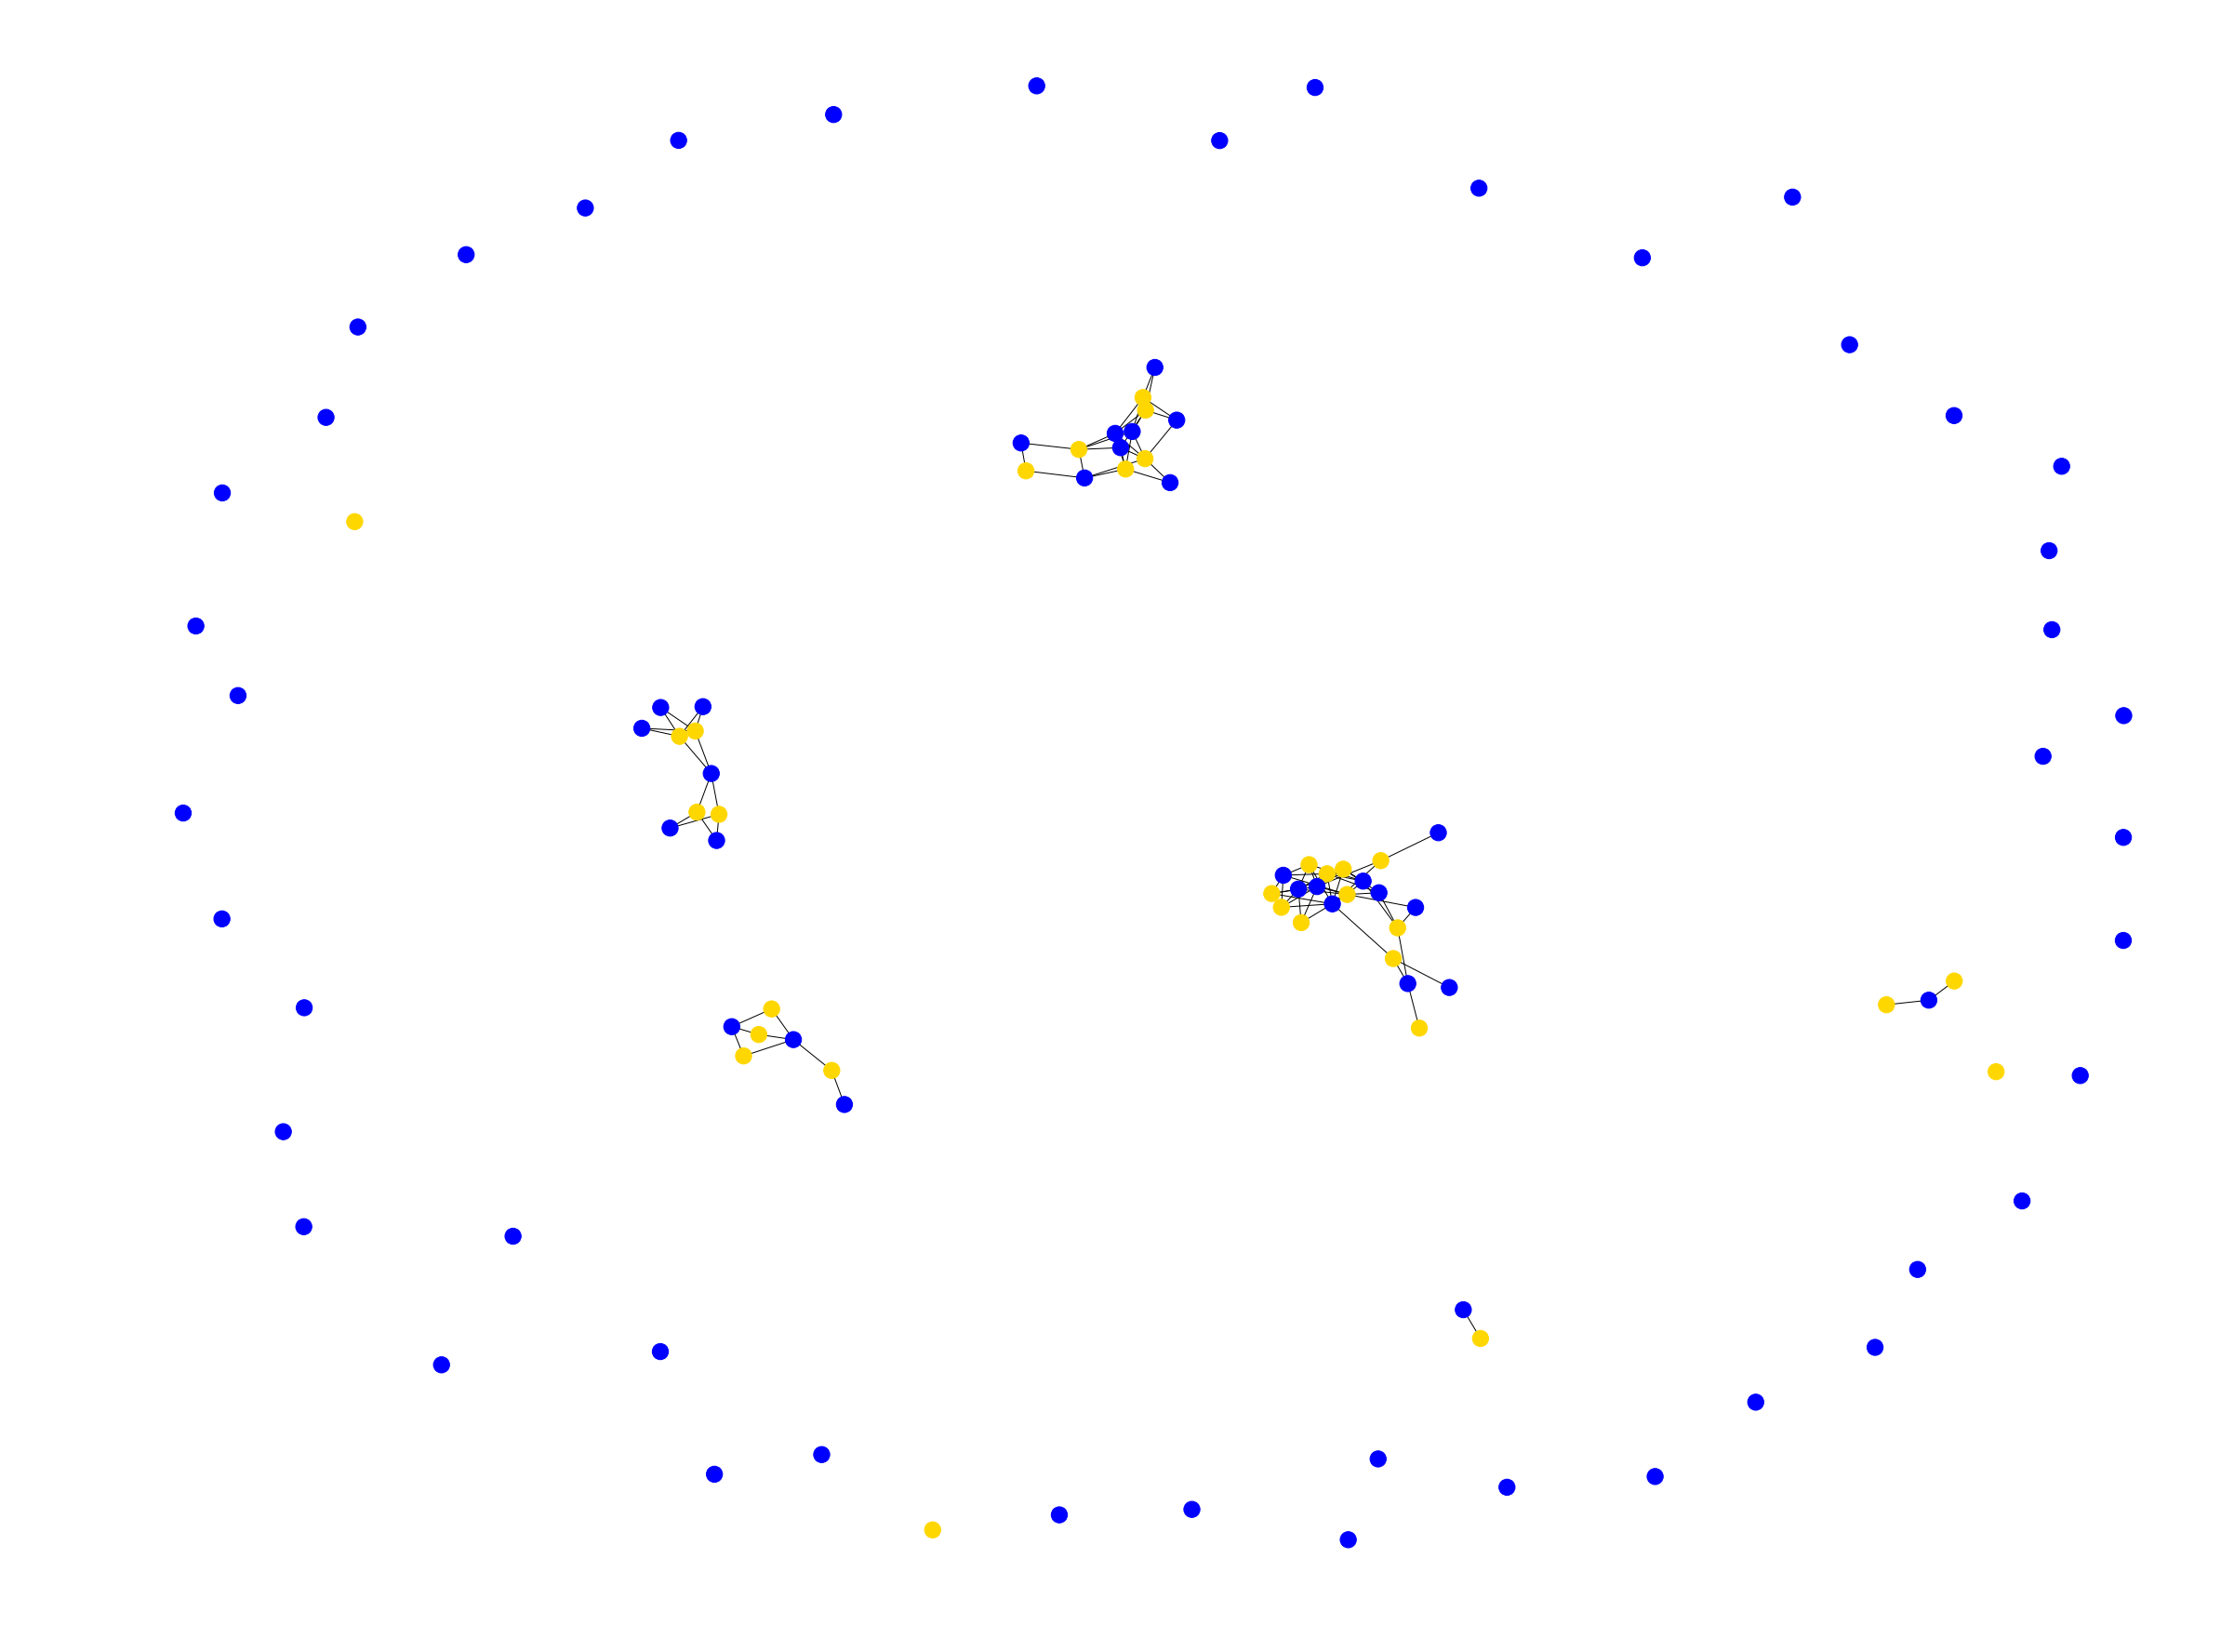

In [14]:
nx.draw(Gr, node_color=colorMap)

In [15]:
file = nx.to_numpy_matrix(G)
print(file.shape)
print()
print(file)
np.savetxt("ResObsProximity.txt",file, "%d")   

NameError: name 'G' is not defined

###  Same, but on hotels vs Obs

In [18]:
observationLocs = list(zip(df['Latitude (WGS84)'], df['Longitude (WGS84)']))
print(len(observationLocs))
observationLocs = cleanObs(observationLocs) 
print(len(observationLocs))
observationLocs = list(filter(lambda x: x[1] > 2,observationLocs))
print(len(observationLocs))
observationLocs = list(map(lambda x: x[0],observationLocs))

hotels = cleanResidences(listedEiggHotels())

5394
293
74


In [19]:
len(hotels), len(observationLocs) 

(16, 74)

In [20]:
Gh, colorMap = graphTwoSetsByObservations(observationLocs,hotels)

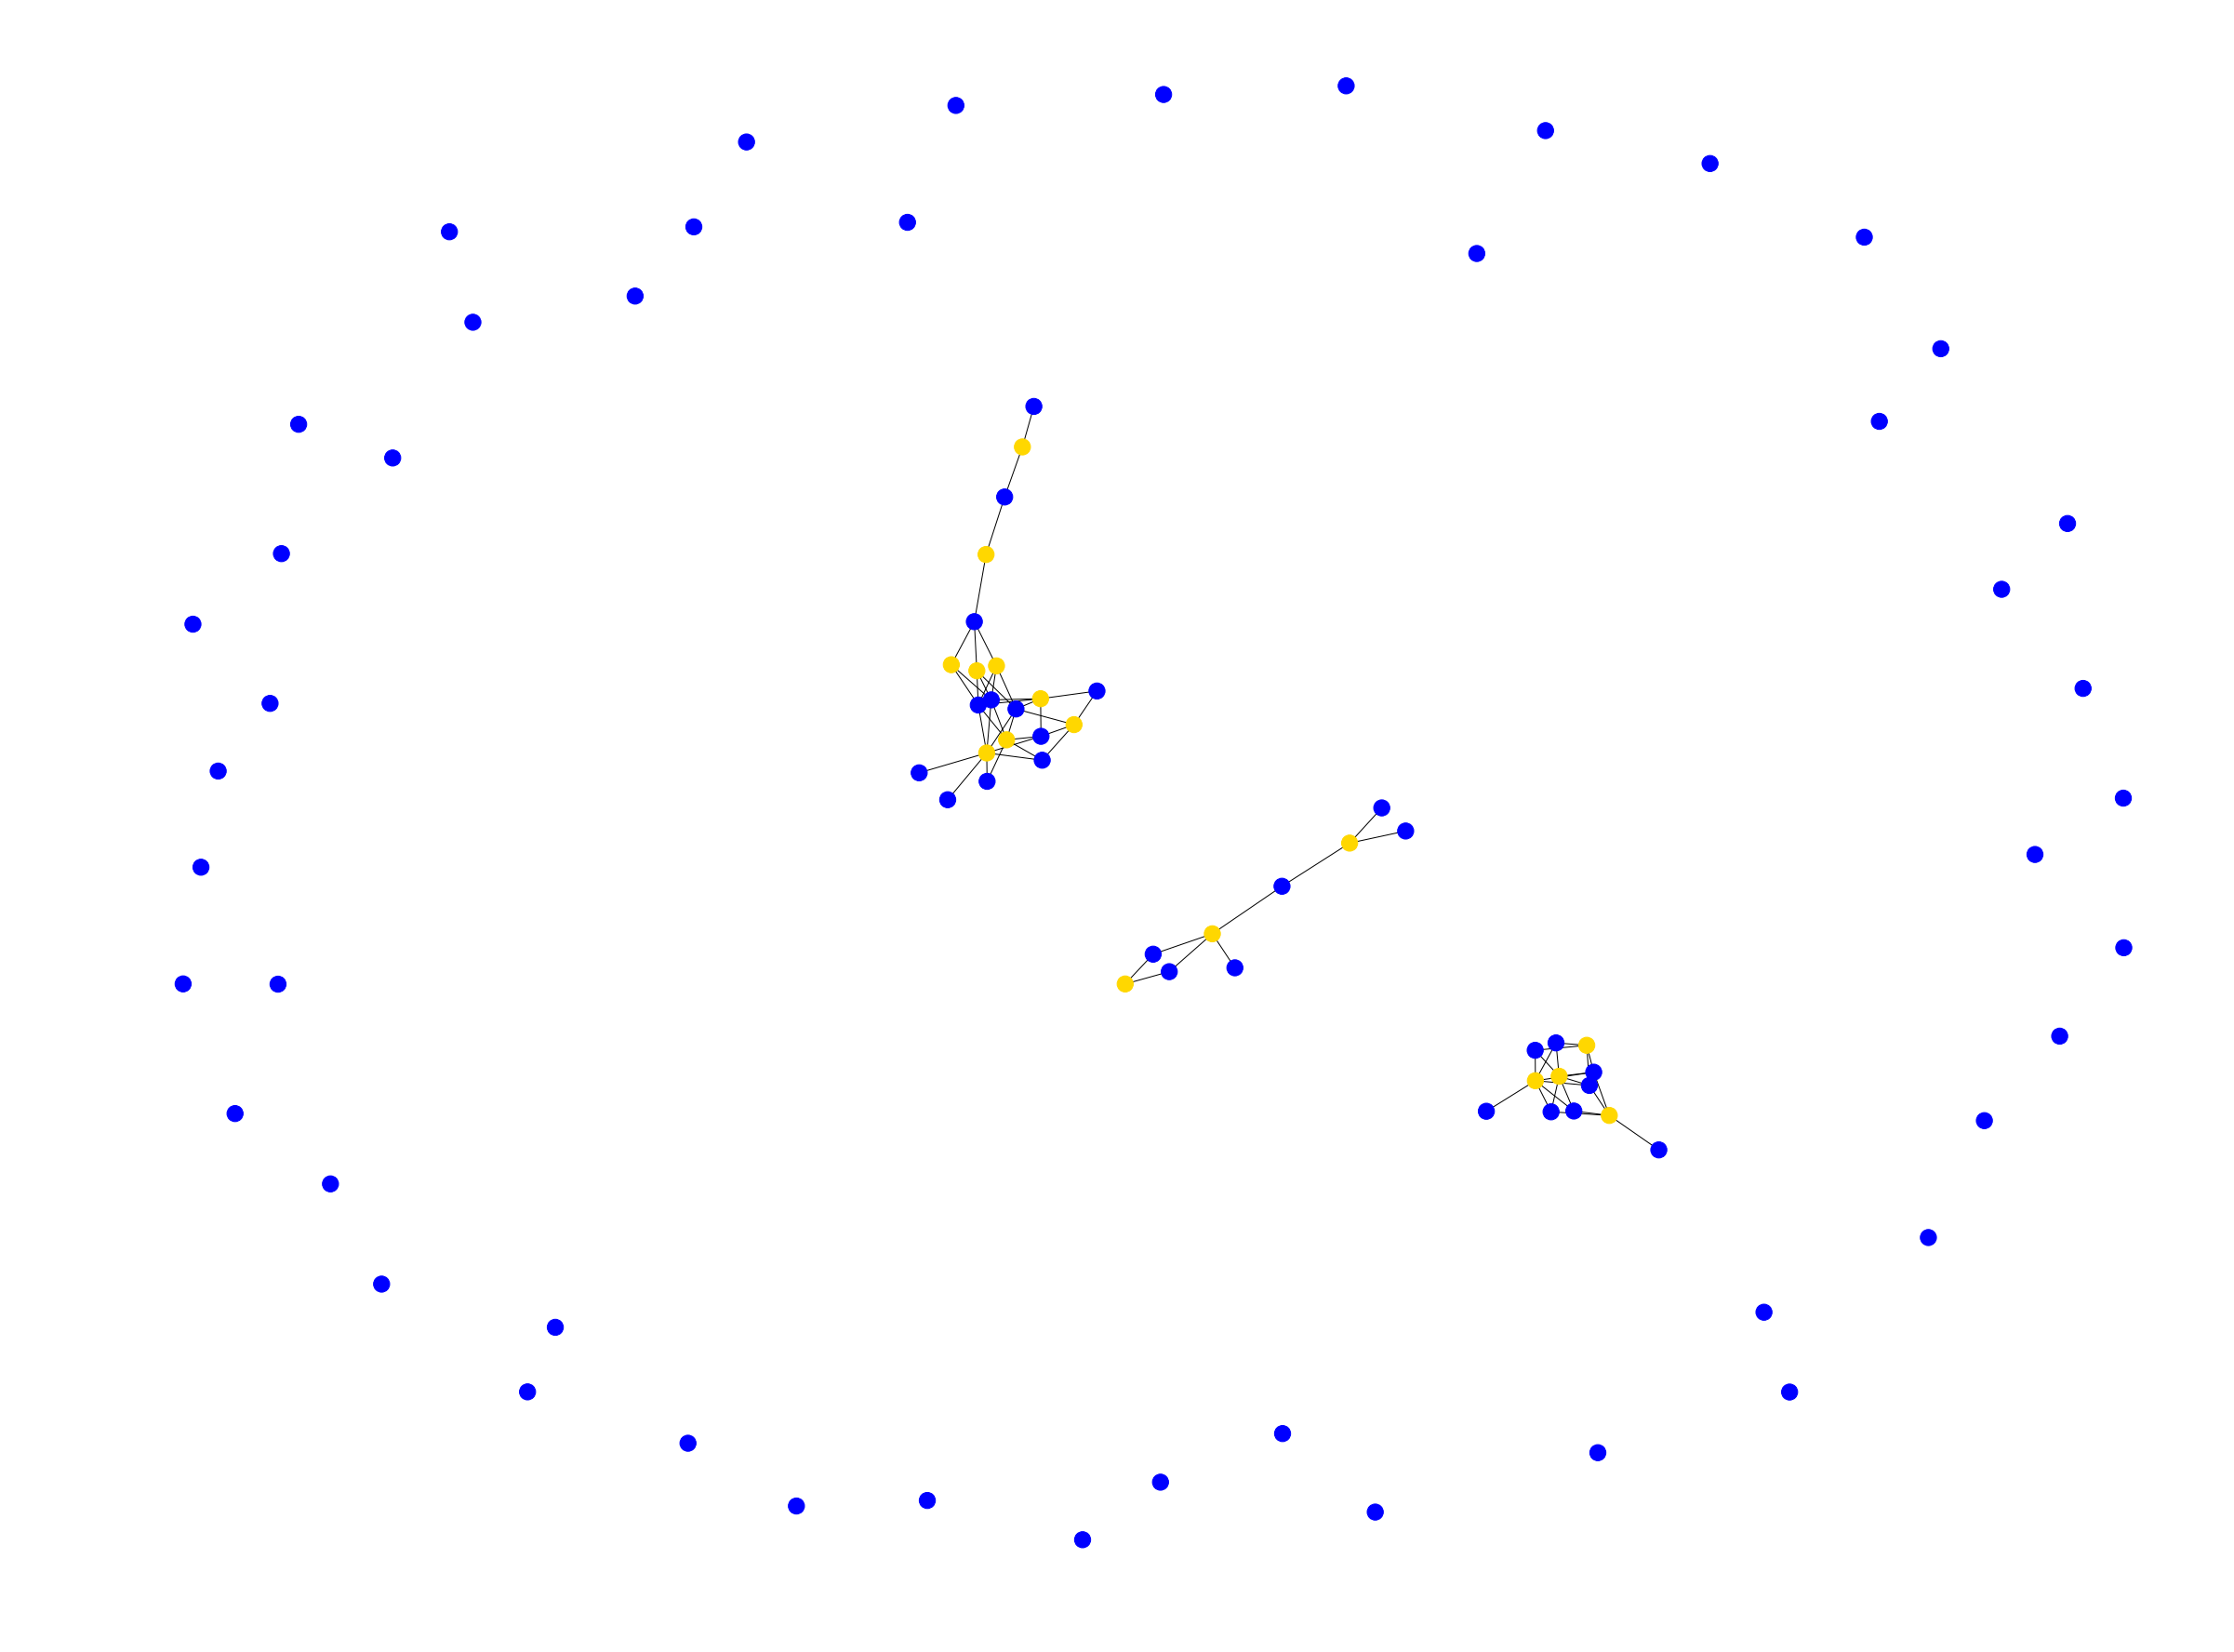

In [21]:
nx.draw(Gh, node_color=colorMap)

In [22]:
Gt, colorMap = graphTwoSetsByObservations(residences,hotels)

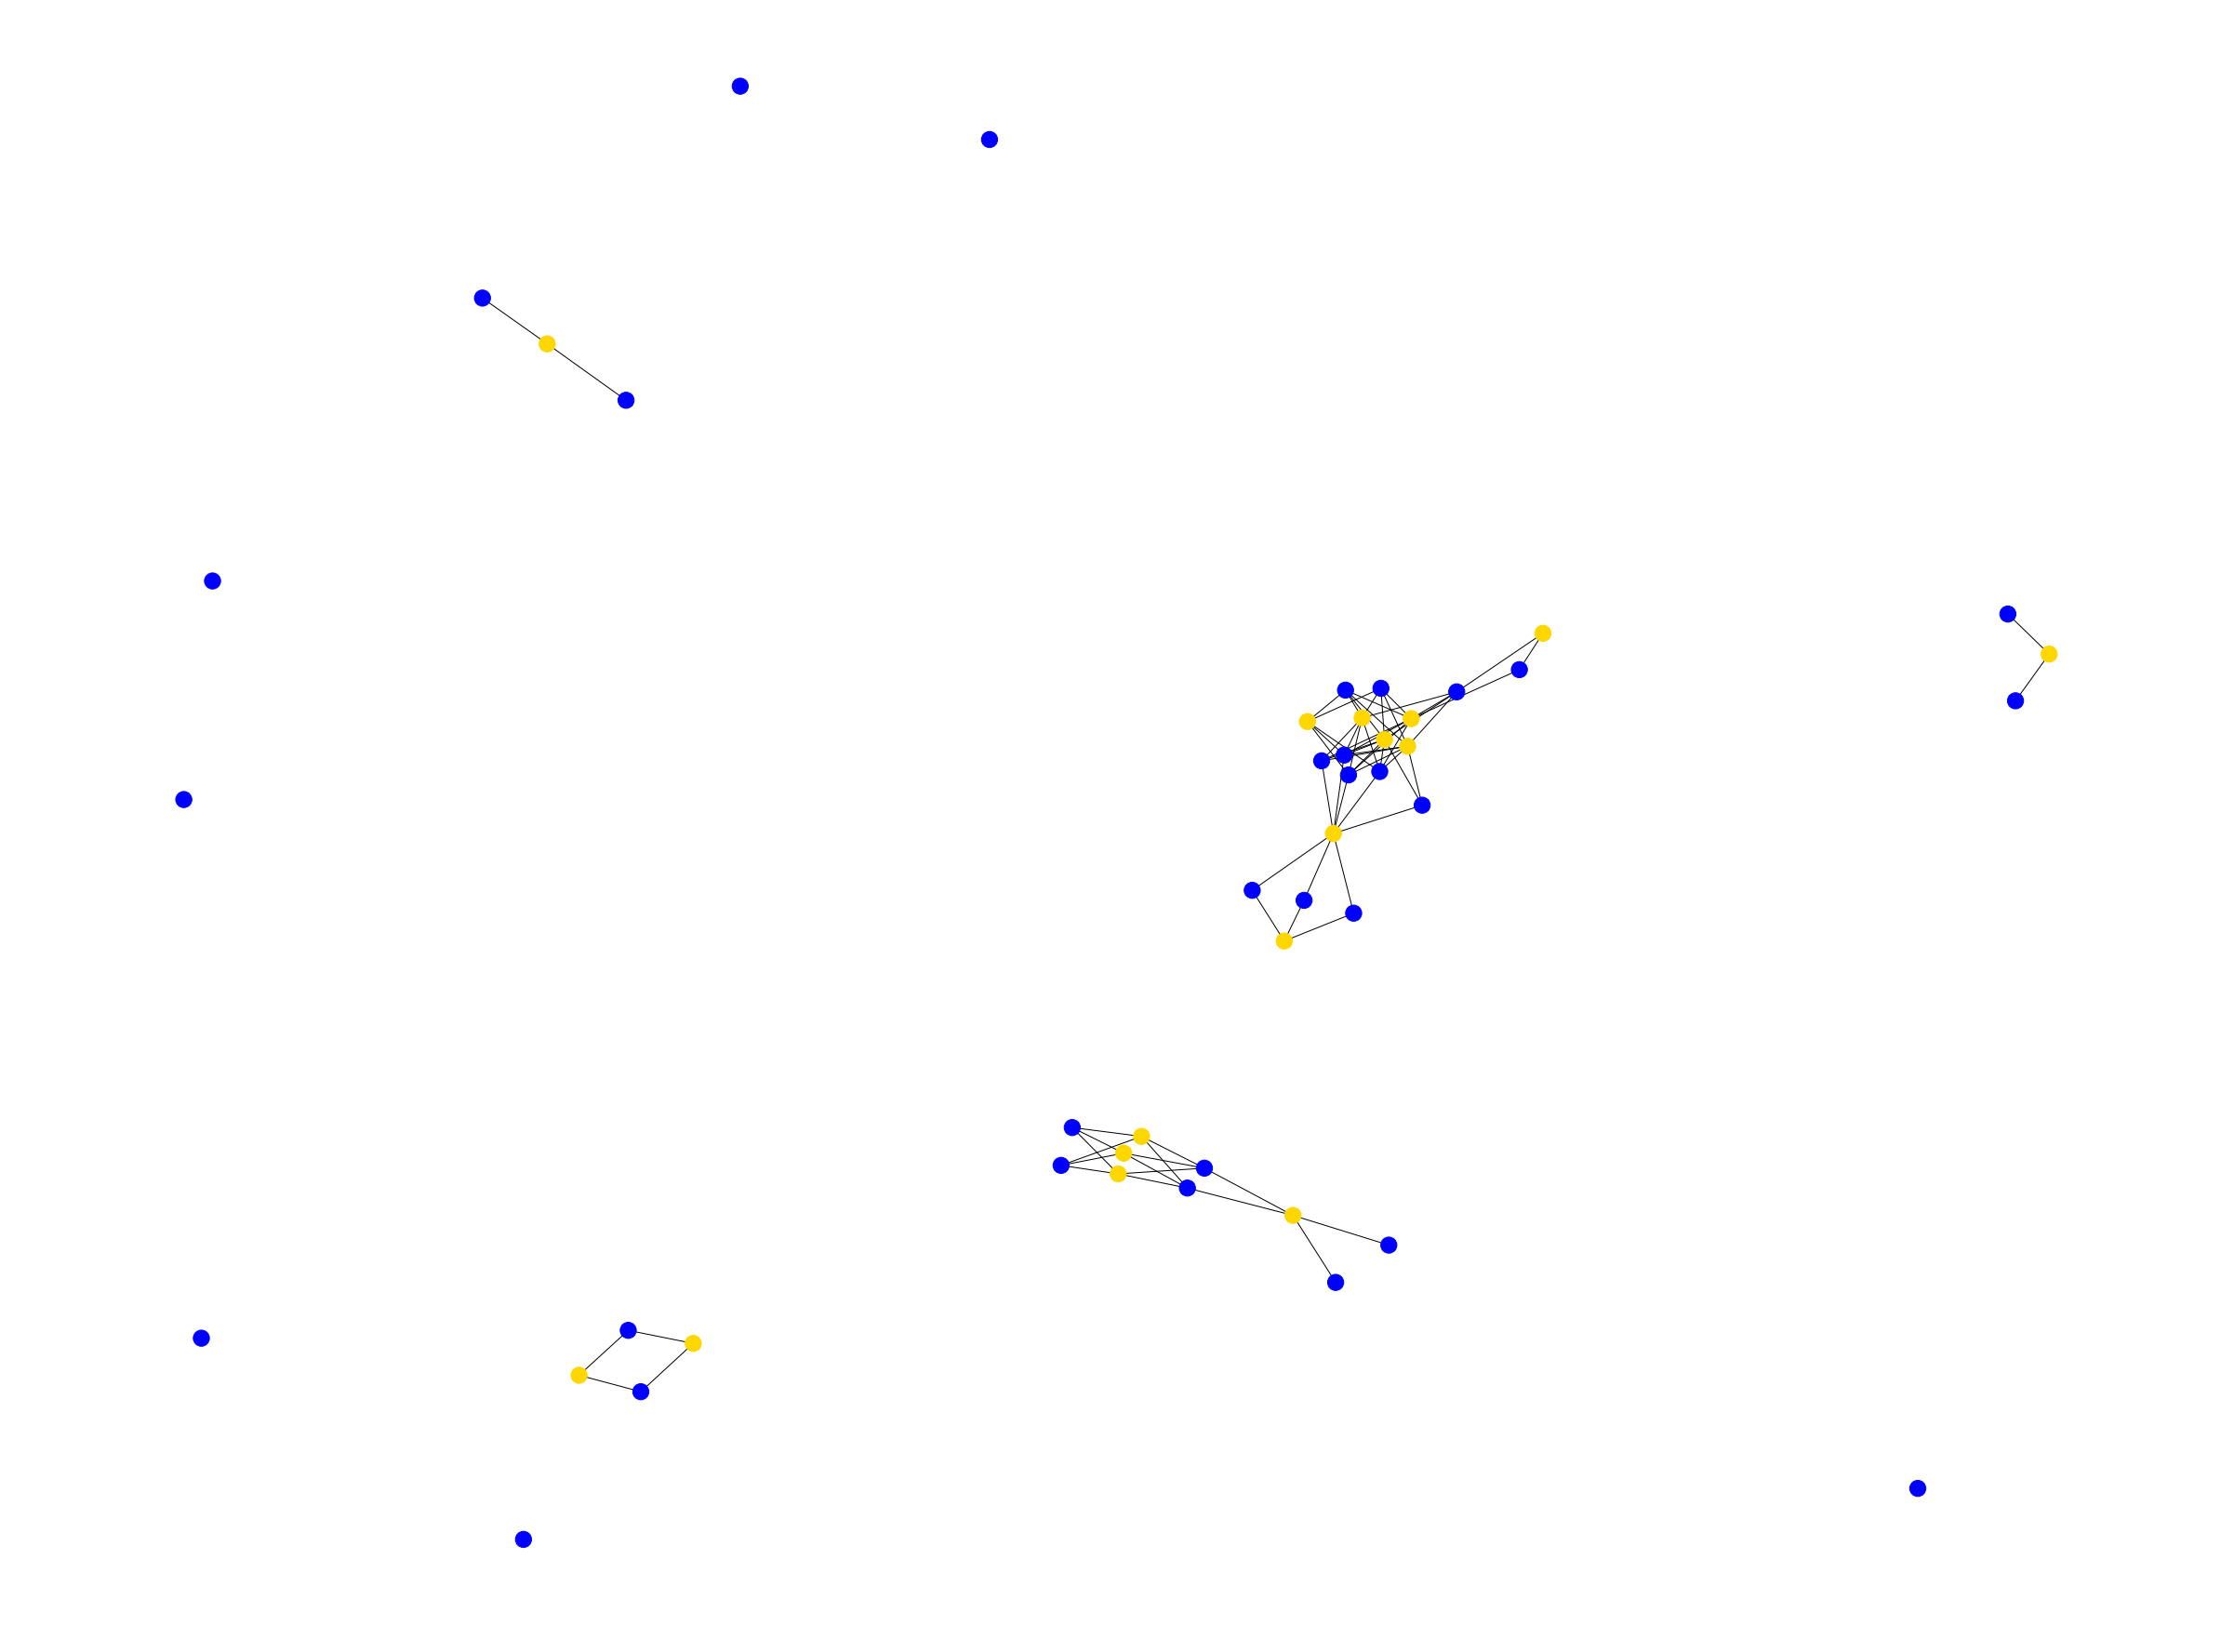

In [23]:
nx.draw(Gt, node_color=colorMap)

In [24]:
print(Gt.number_of_edges())
print(Gh.number_of_edges())
print(Gr.number_of_edges())

73
69
97


# Extra- "Points of interest" comparison

Refer to notes regarding impact

In [25]:
observationLocs = list(zip(df['Latitude (WGS84)'], df['Longitude (WGS84)']))
print(len(observationLocs))
observationLocs = cleanObs(observationLocs) 
print(len(observationLocs))
observationLocs = list(filter(lambda x: x[1] > 2,observationLocs))
print(len(observationLocs))
observationLocs = list(map(lambda x: x[0],observationLocs))

interests = cleanResidences(pointsOfInterest())

5394
293
74


In [26]:
Gi, colorMap = graphTwoSetsByObservations(observationLocs,interests)

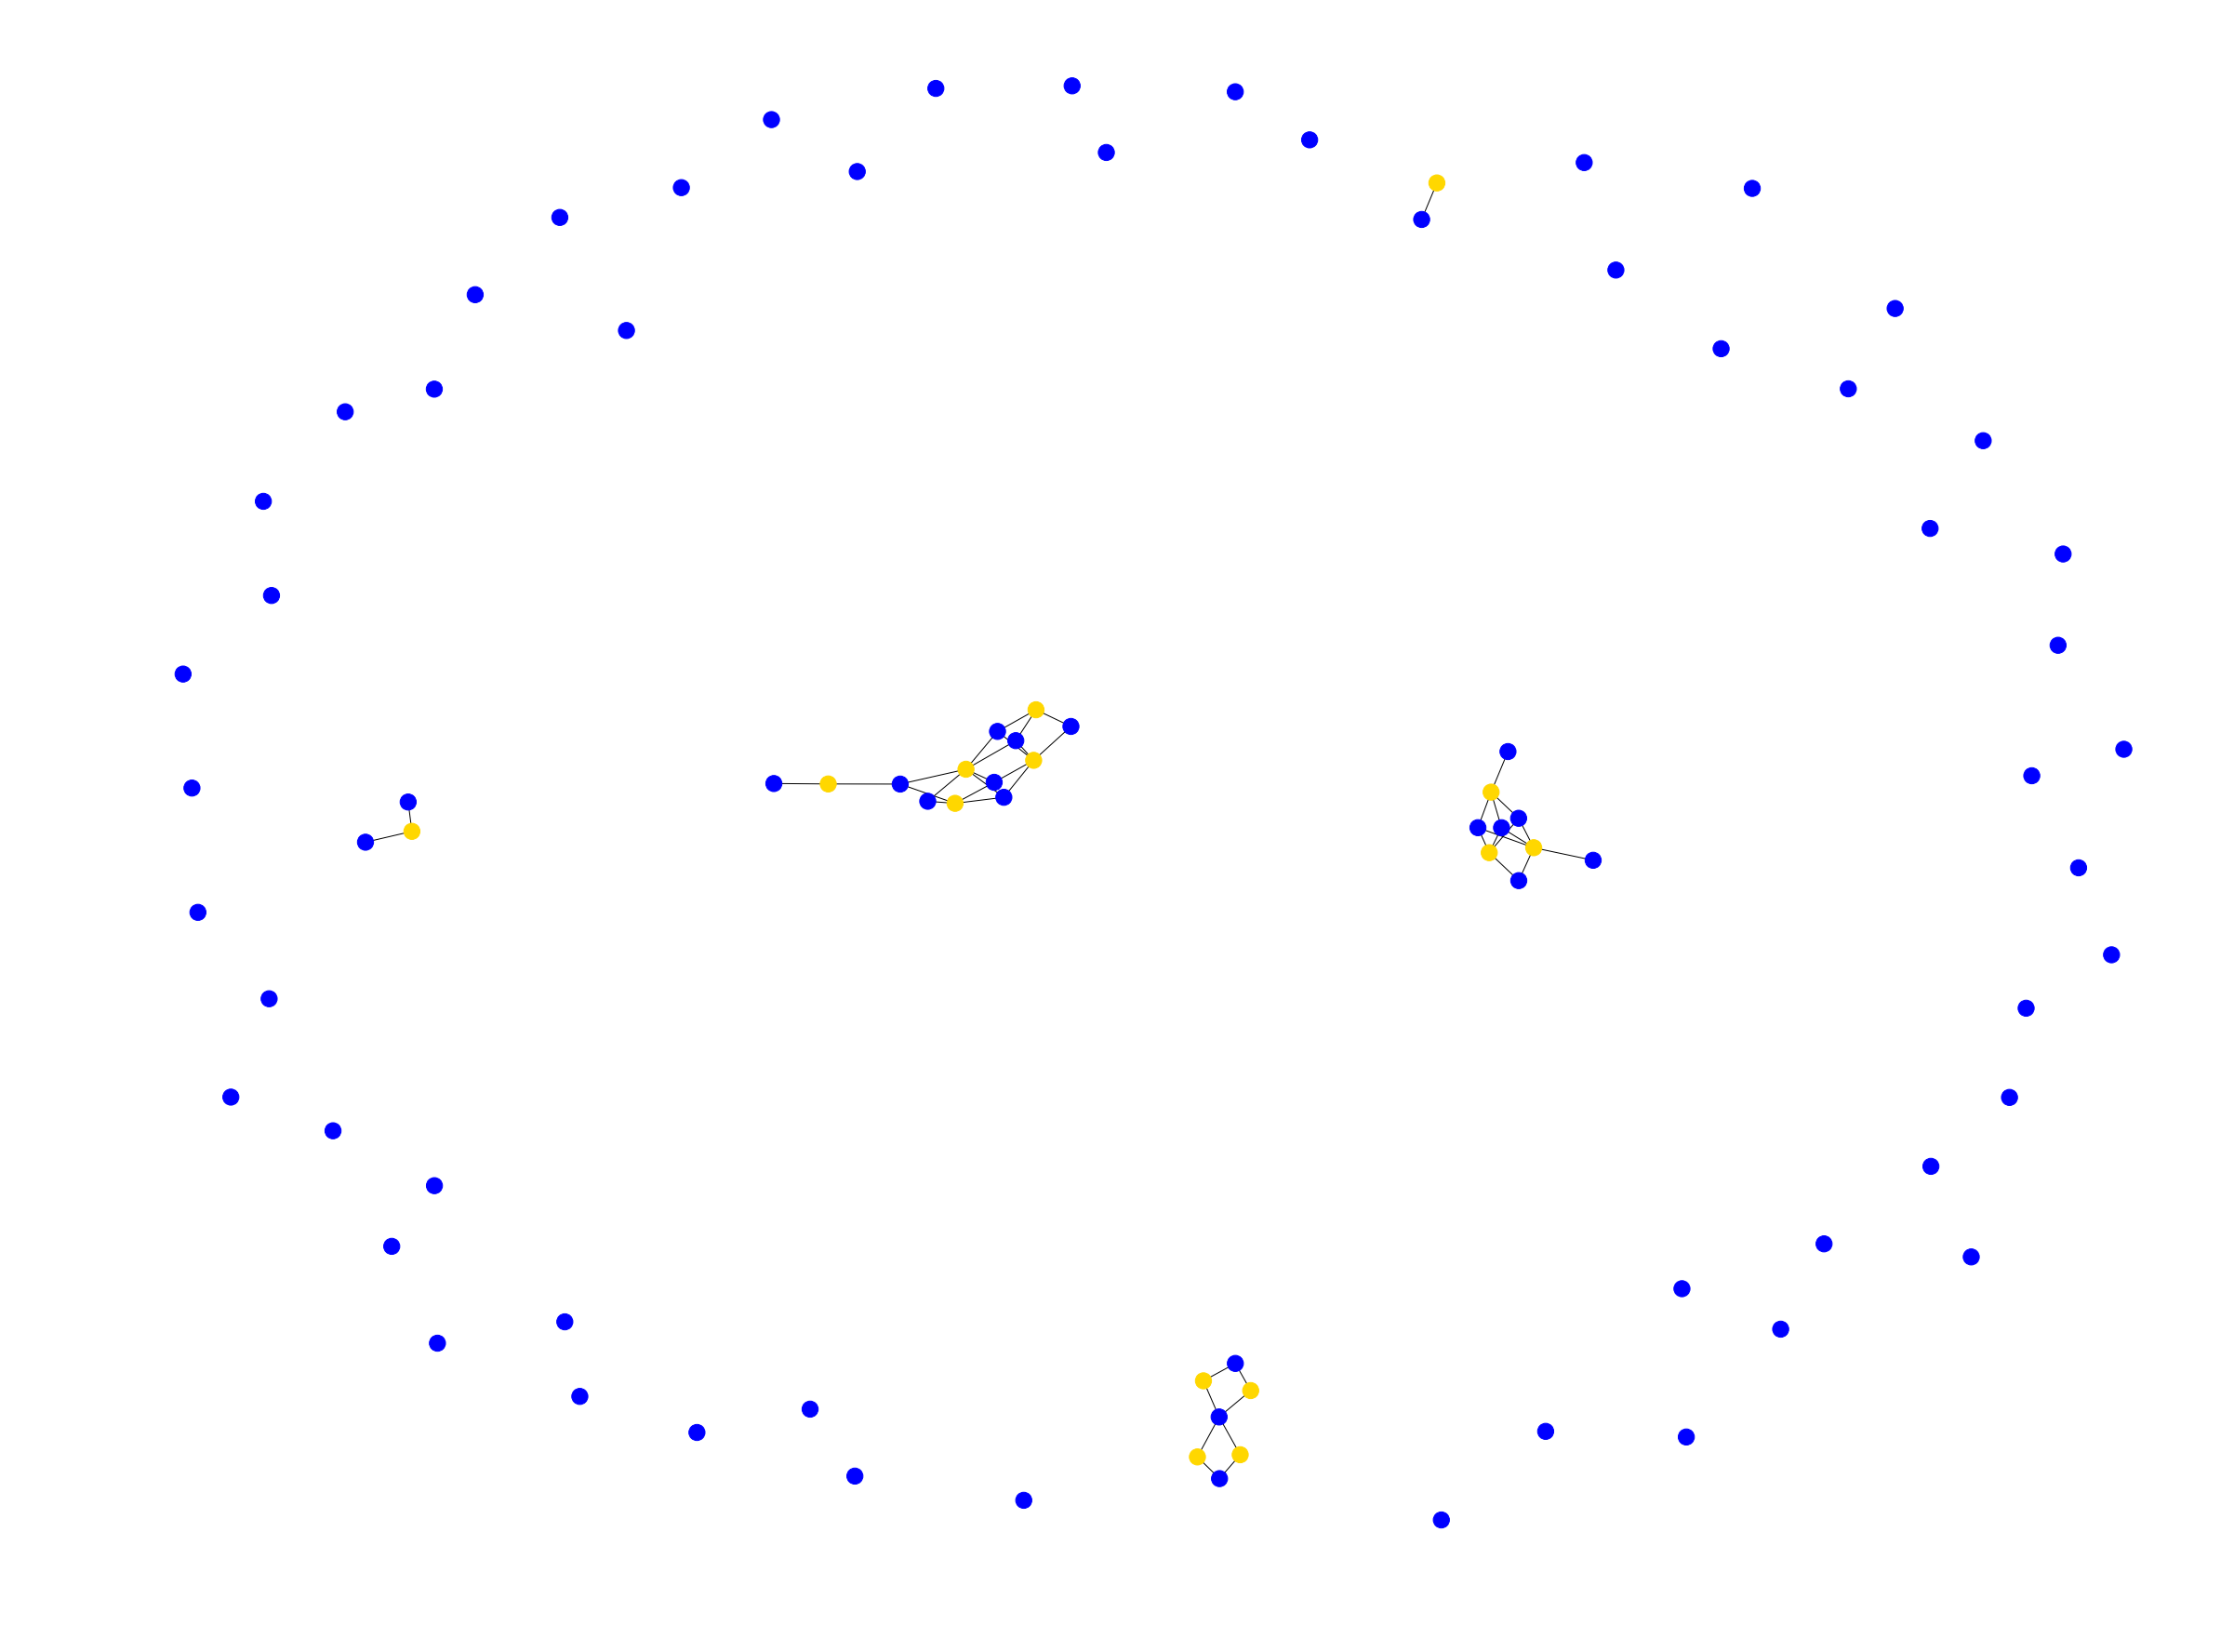

In [27]:
nx.draw(Gi, node_color=colorMap)

In [28]:
Goi, colorMap = graphTwoSetsByObservations(hotels,interests)

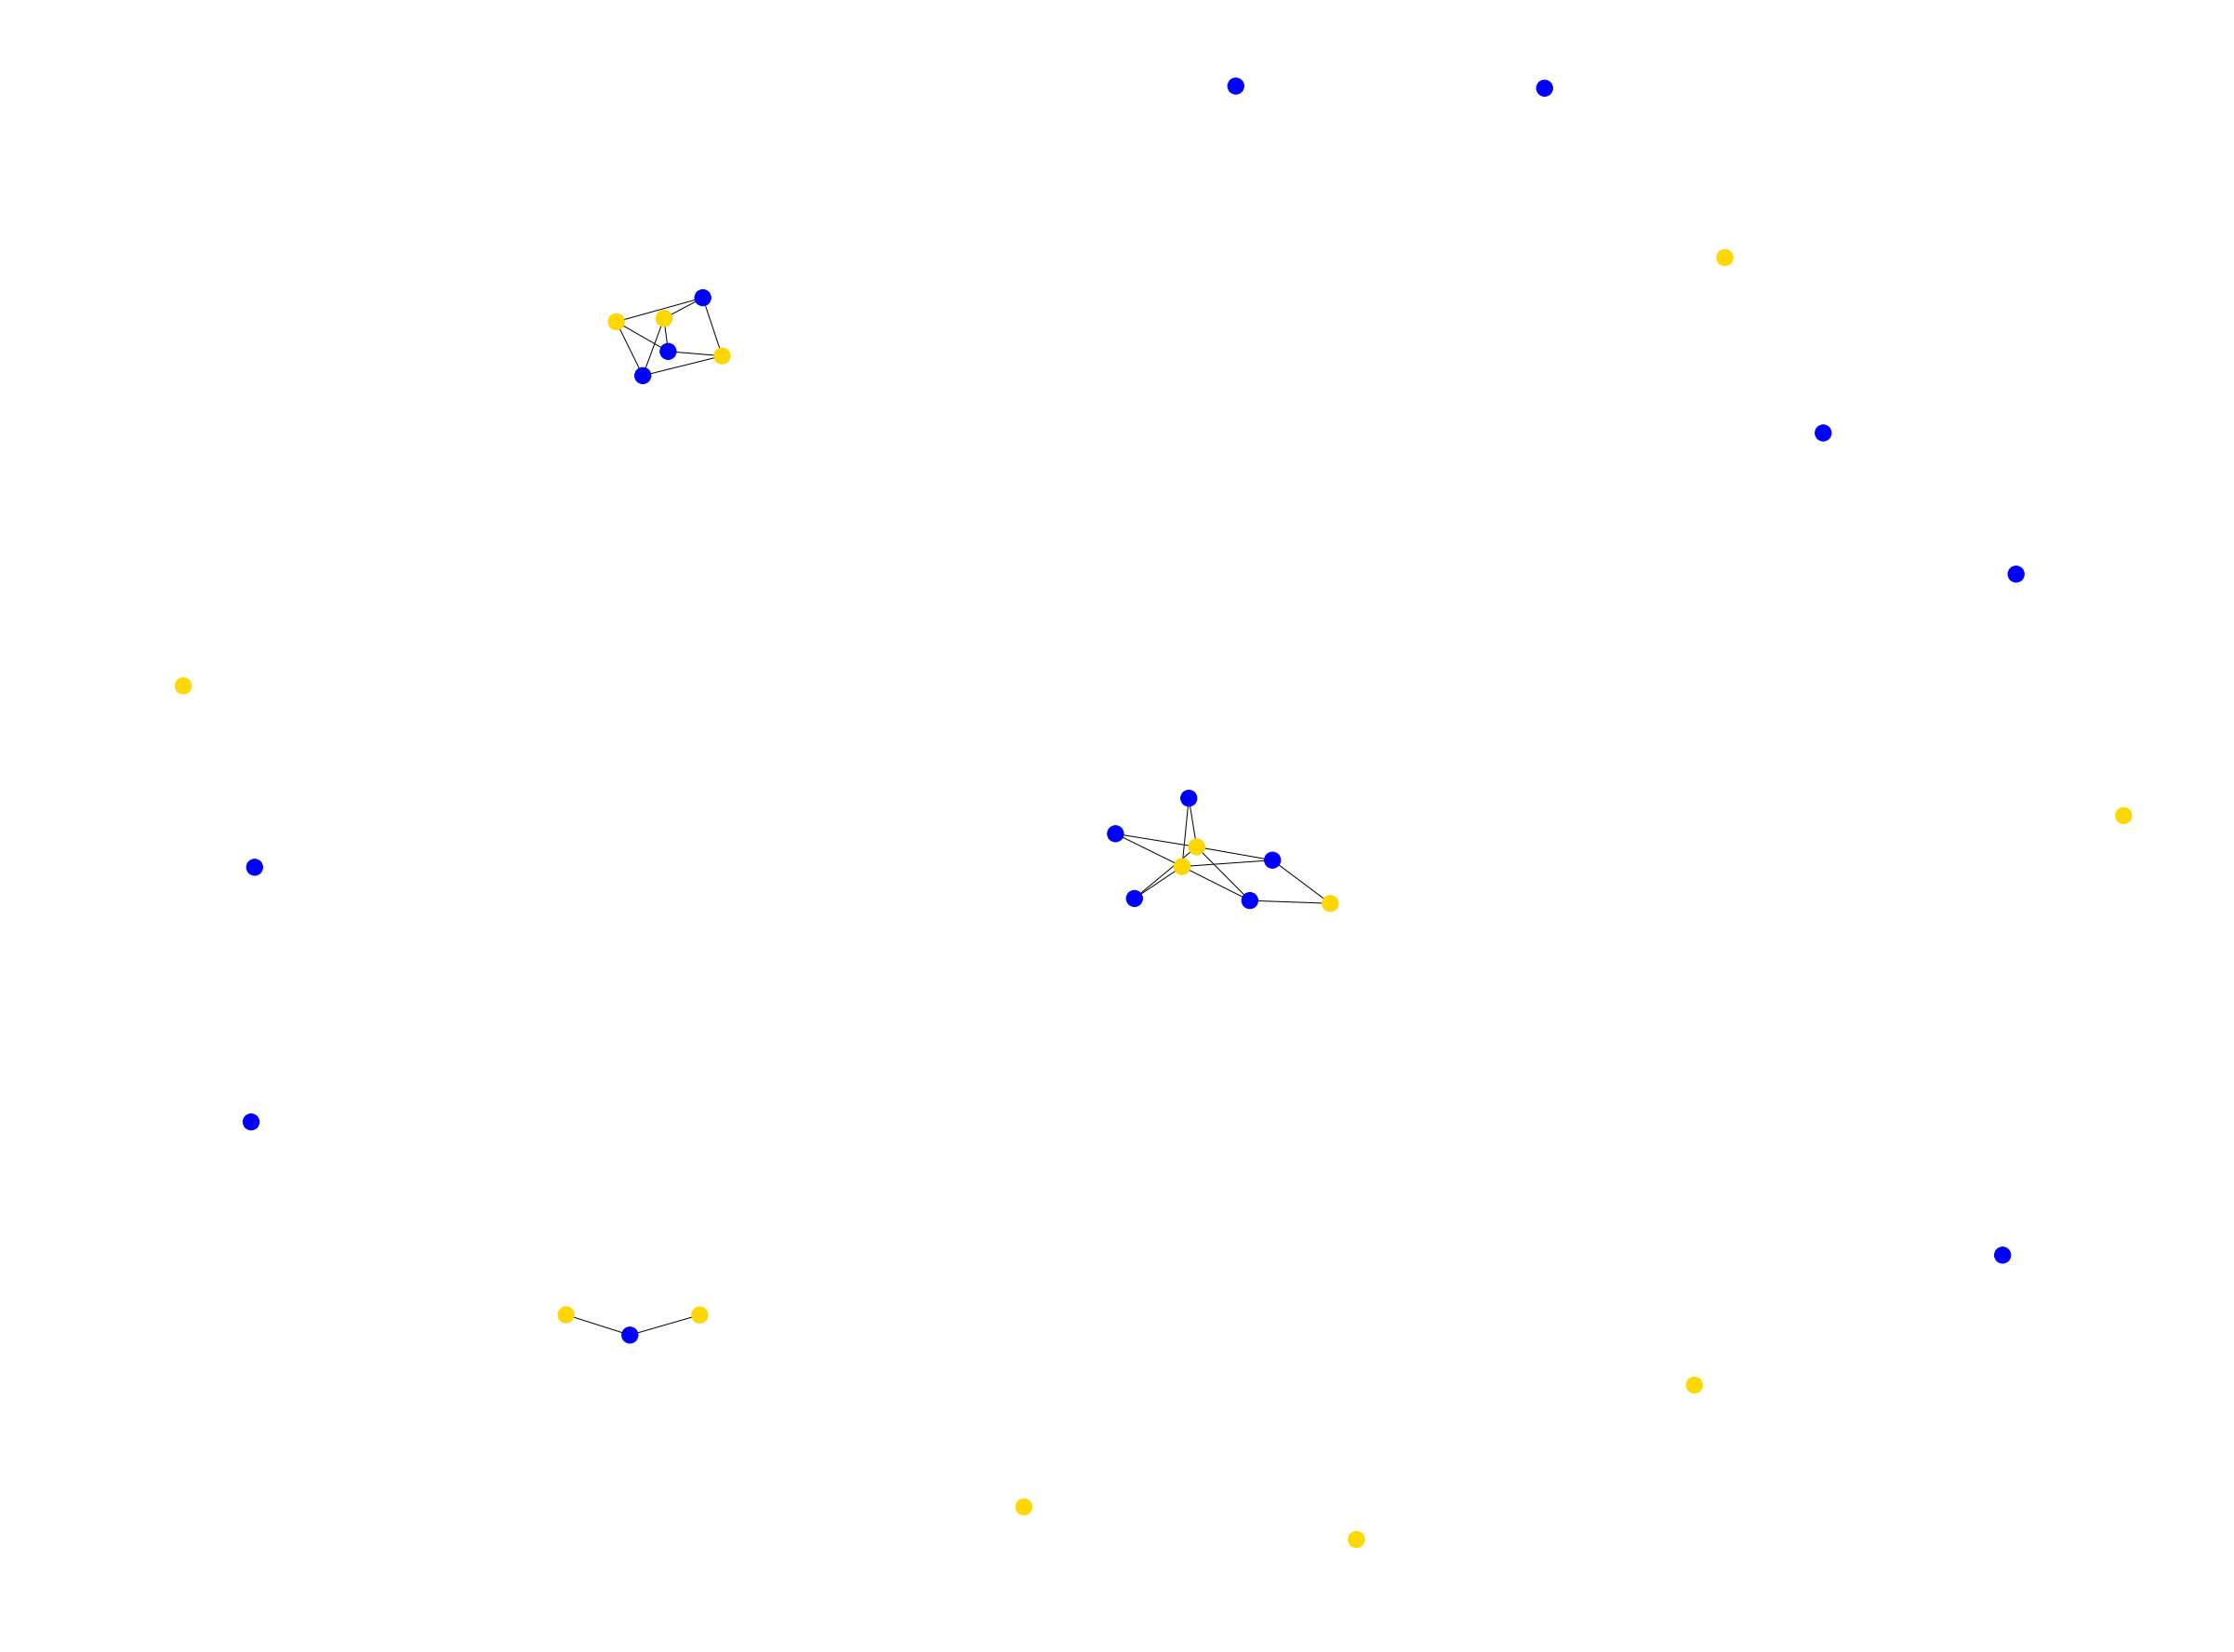

In [29]:
nx.draw(Goi, node_color=colorMap)

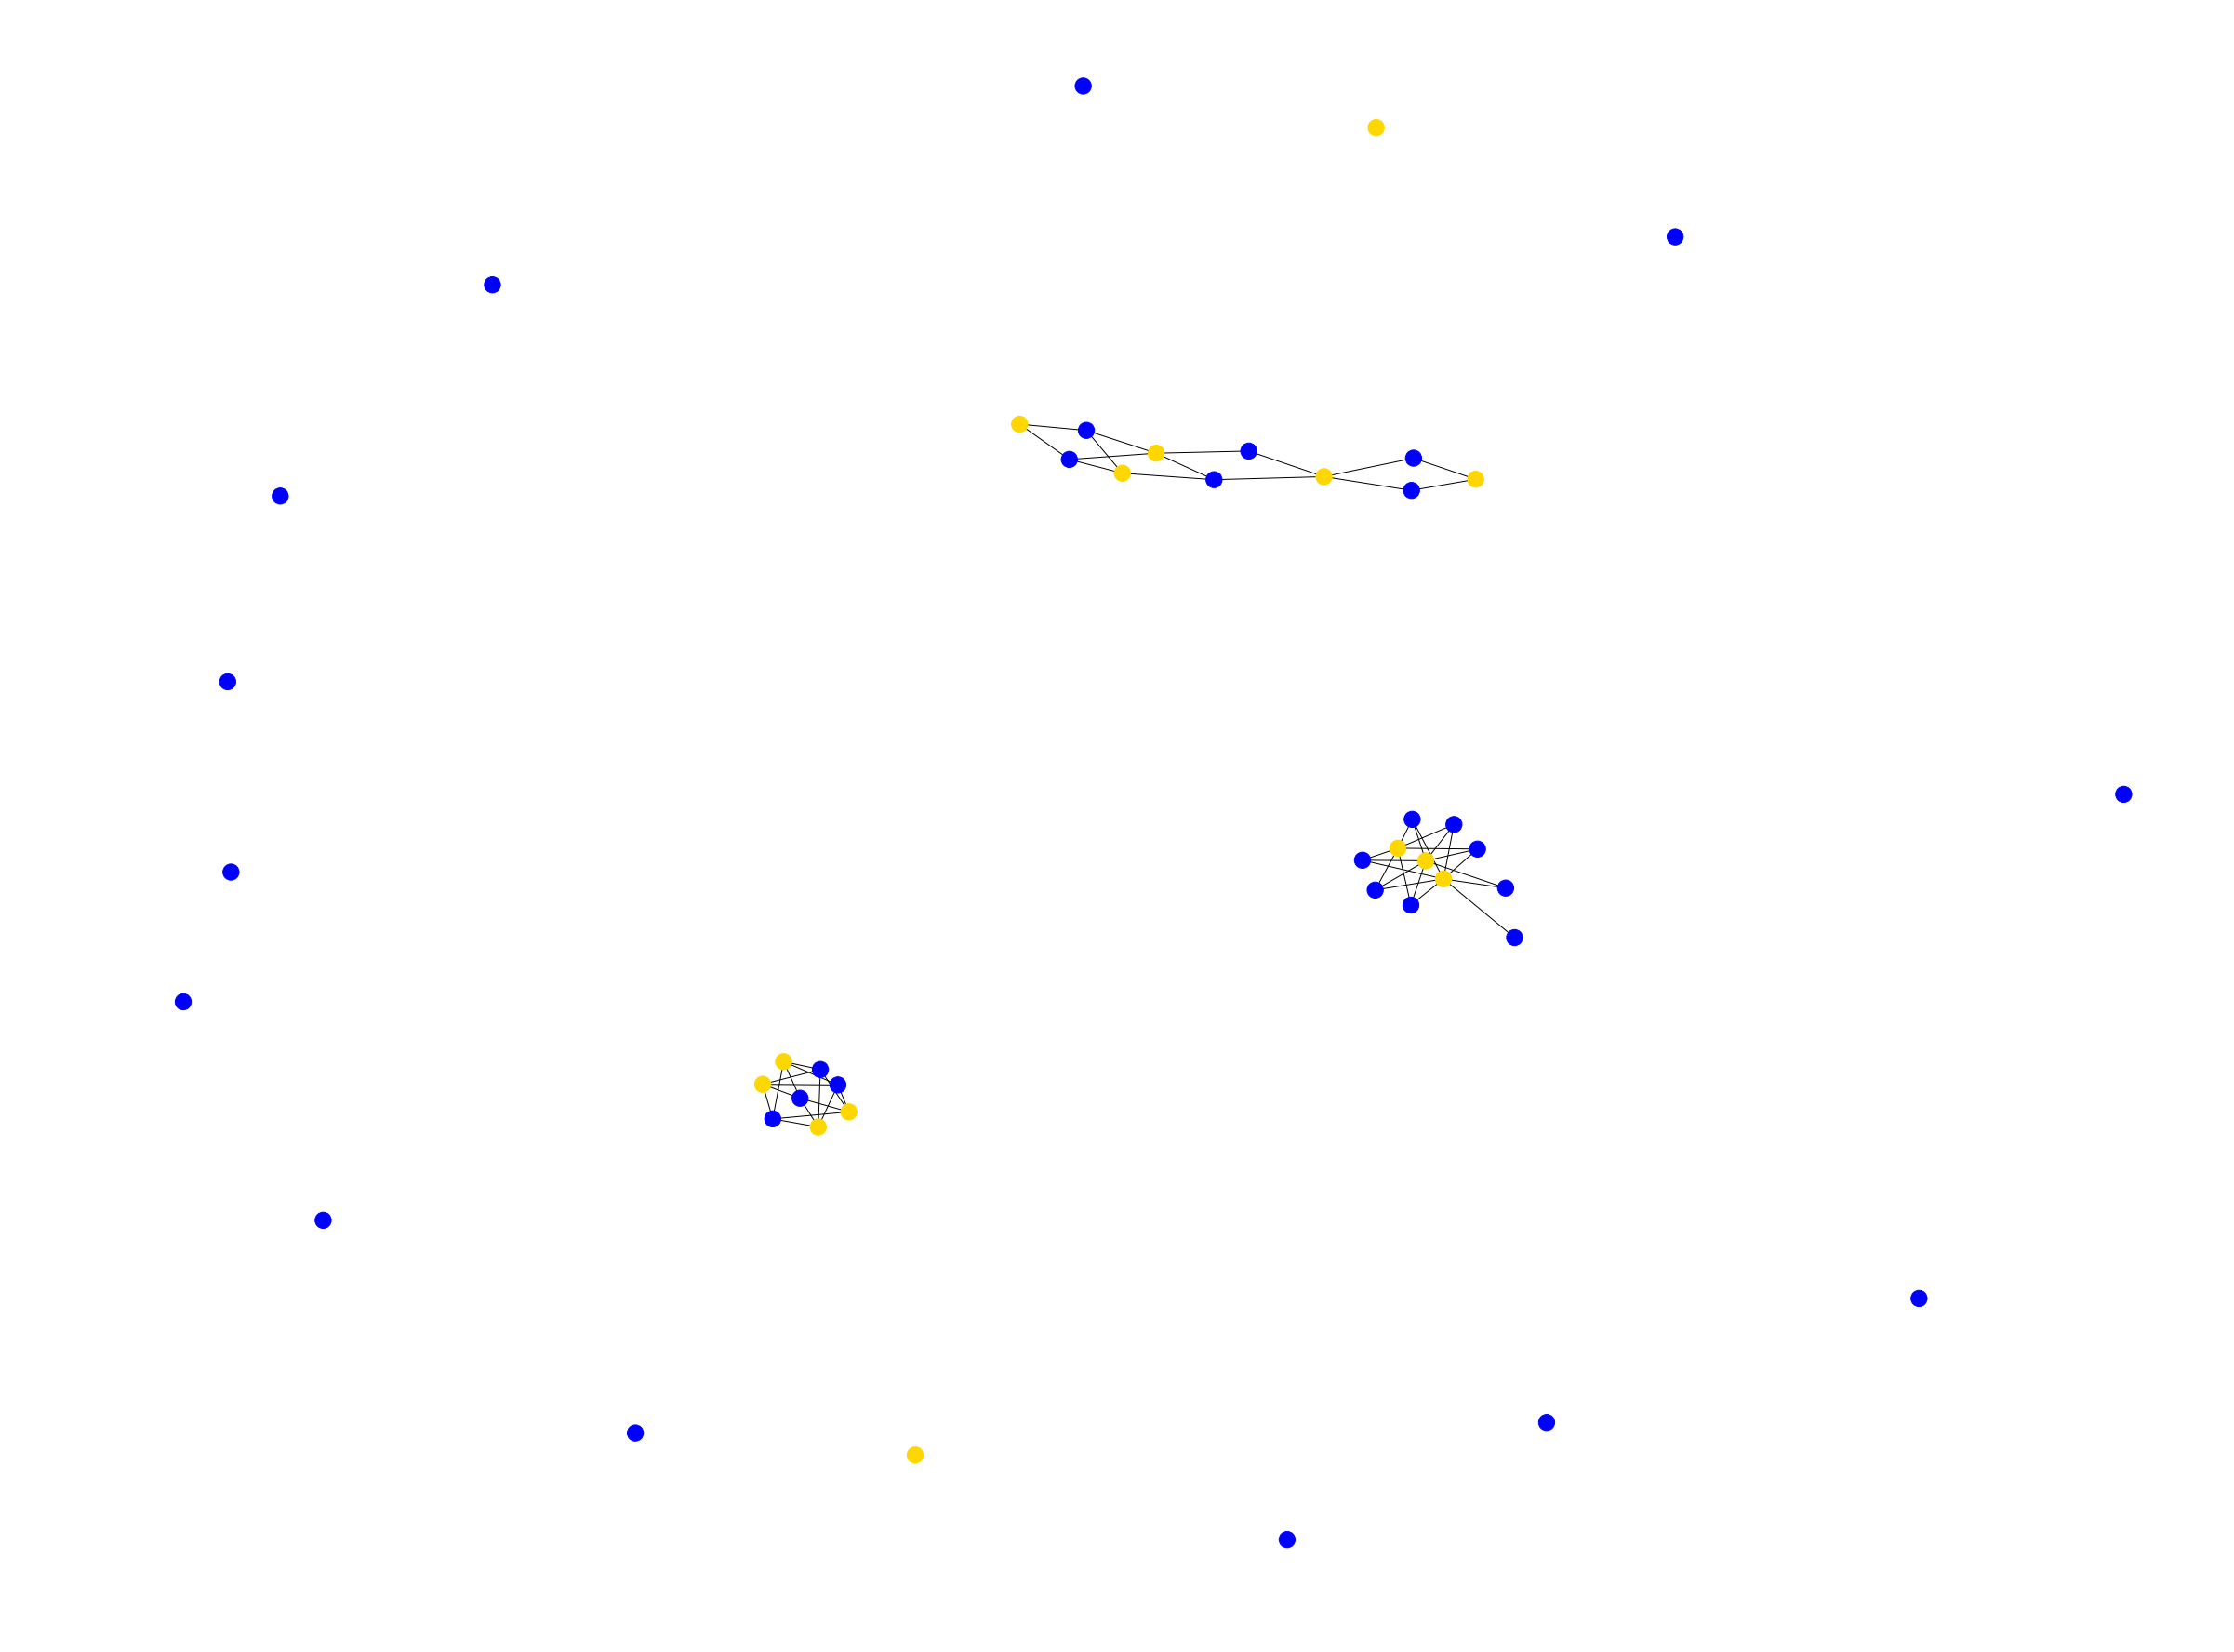

In [30]:
Gri, colorMap = graphTwoSetsByObservations(residences,interests)
nx.draw(Gri, node_color=colorMap)